# Codebook Overview

We have explored our dataset and created necessary features in our last codebook. Here we will run multiple models on our engineered dataset to find the best one. Lastly, we will use our best model to predict the first we revenue for the 3rd Avatar movie. In this code book we:

* Try out different models
* Use the best model to further tweak it for our specific case
* Predict revenue of Avatar: Fire and Ash

# Installing Dependencies

In [1]:
# Installing all libraries just to be sure
import sys, subprocess; subprocess.check_call([sys.executable, "-m", "pip", "install", "numpy", "shap", "xgboost", "lightgbm", "catboost", "seaborn", "scikit-learn", "pandas", "matplotlib"])

0

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
# FAILSAFE SHAP IMPORT (This module shows errors at times)
try:
    import shap
    print("✅ SHAP imported successfully.")
except Exception as e:
    print(f"⚠️ WARNING: Could not import SHAP. (Error: {e})")
    print("   -> The code will continue, but SHAP plots will be skipped.")
    shap = None  # Prevents "NameError" if you check for it later
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tqdm.notebook import tqdm
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

✅ SHAP imported successfully.


# Loading The Dataset

Next we load the dataset containing our features to be used for modelling. The process will happen automatically but I have also attached a link to the csv.

[Dataset Link](https://drive.google.com/file/d/1GFFkJ_LtpwsSXHcL6nTte2qevbWF0vRq/view?usp=drive_link)

In [3]:
# AUTO-INSTALL GDOWN
try:
    import gdown
except ImportError:
    print("Installing gdown...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gdown"])
    import gdown

# CONFIGURATION
file_link = "https://drive.google.com/file/d/1GFFkJ_LtpwsSXHcL6nTte2qevbWF0vRq/view?usp=drive_link"
filename = "df_features_final.csv"

# DOWNLOAD LOGIC
if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    try:
        # Extract ID and Download
        file_id = file_link.split('/d/')[1].split('/')[0]
        url = f'https://drive.google.com/uc?id={file_id}'
        gdown.download(url, filename, quiet=False)
    except IndexError:
        print("❌ Error: The link format looks wrong. Use the standard 'Share' link.")
else:
    print(f"Found {filename} locally.")

# LOAD DATA
df_model = pd.read_csv(filename)
print(f"✅ Loaded {filename}. Shape: {df_model.shape}")

Downloading...
From: https://drive.google.com/uc?id=1GFFkJ_LtpwsSXHcL6nTte2qevbWF0vRq
To: /content/df_features_final.csv
100%|██████████| 992k/992k [00:00<00:00, 37.9MB/s]

✅ Loaded df_features_final.csv. Shape: (1713, 65)


In [4]:
# We are creating a copy of df_model so that we can reuse it after modifications
df_model_initial = df_model.copy()

# Preparing for Modeling

We do some final cleaning before getting started with the modeling section

We drop the columns not needed for modeling (IDs, text, leaky features)

In [5]:
columns_to_drop = [
    'director_popularity',
    'main_actor_popularity',
    'cast_popularity_sum',
    'imdb_id',
    'collection_name',
    'collection_id',
    'keywords',
    'production_companies',
    'director',
    'director_id',
    'top_cast',
    'main_actor_name',
    'main_actor_id',
    'primaryTitle',
    'Distributor',
    'release_date',
    'holiday_name',
    'mpaa_rating',
    'genres',
    'prequel_revenue', # We created an updated one later on
    'main_production_company',
]

df_model = df_model.drop(columns=columns_to_drop, errors='ignore')
df_model.head()

,budget,first_week_revenue,runtimeMinutes,Theaters,year,is_major_holiday,month_August,month_December,month_February,month_January,...,has_low_yield_genre,budget_tier_numeric,has_prequel,prequel_revenue_fixed,franchise_position,years_since_last_installment,Source_Comic_Graphic_Novel,budget_per_theater,avg_ticket_price,consumer_sentiment
0,245000000,390856054,138.0,4134.0,2015,1,0,1,0,0,...,0,4,0,57186770.0,1.0,0.000000,0,59264.634736,8.43,92.9
1,300000000,296602356,152.0,4232.0,2017,0,0,1,0,0,...,0,4,1,390856054.0,2.0,1.993155,0,70888.468809,8.97,96.8
2,489900000,289796816,141.0,4406.0,2019,1,0,1,0,0,...,0,4,1,296602356.0,3.0,2.012320,0,111189.287335,9.16,96.0
3,294700000,94705329,154.0,4600.0,2023,1,0,0,0,0,...,0,4,0,57186770.0,1.0,0.000000,0,64065.217391,10.94,65.3
4,250000000,225011359,164.0,4404.0,2012,0,0,0,0,0,...,0,4,0,57186770.0,1.0,0.000000,0,56766.575840,7.96,76.6


In [6]:
df_model.columns

Index(['budget', 'first_week_revenue', 'runtimeMinutes', 'Theaters', 'year',
       'is_major_holiday', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'competition_count', 'director_bankability',
       'actor_bankability', 'director_experience', 'is_covid_period',
       'dist_cat_Medium', 'dist_cat_Small', 'distributor_bankability',
       'mpaa_rank', 'has_top_yield_genre', 'has_high_yield_genre',
       'has_medium_yield_genre', 'has_low_yield_genre', 'budget_tier_numeric',
       'has_prequel', 'prequel_revenue_fixed', 'franchise_position',
       'years_since_last_installment', 'Source_Comic_Graphic_Novel',
       'budget_per_theater', 'avg_ticket_price', 'consumer_sentiment'],
      dtype='object')

# Modeling (Testing Multiple Models)

We try our different models here to pick the best one. You can skip this section if you wish to see our final modeling only.

**Key points**

* We will apply **log transformation** on Budget and Revenue (target) to normalize the massive range of box office returns

* We will compare multiple models to find the best one

* We will do hyperparameter tuning on each model and take measures to tackle overfitting


**Cross Validation is Key**
* We will do K-fold cross validation to ensure our results are robust. This step is very important because our dataset has lots of smaller releases as there aren't many major blockbusters like Avatar. Models tend to regress to the mean and thus predicting a high revenue film is much harder. If our train set luckily has most of the few high revenue films, it will have an easier time predicting the low revenue films. So to deal with this issue we ensure our model acutally predicts performance of high revenue films thorugh cross validation. The metrics we get from cross validation will not be inflated by a lucky test set and give us the actual picture of how our model performs.

**Preparing the dataset for modeling**

* We do train test split and create our training and validation sets
* We also do log transformation on budget and revenue. We saw earlier that budget and revenue is heavily skewed. Taking it into log scale helps smooth the effect of skewness

In [7]:
# We drop the target and the budget variable which we will log transform
cols_to_drop = ['first_week_revenue', 'budget']
X = df_model.drop(columns=cols_to_drop)

# Transformation
X['budget_log'] = np.log1p(df_model['budget'])
y = np.log1p(df_model['first_week_revenue']) # We log transform the target

# Handle Missing Values
X = X.fillna(0)

## Train Test Split

We do a train test split of the dataset. We will use the training and testing sets created here to try our all the models we are working with so far

In [8]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Linear Regressor (Baseline Model)

This like serve as a baseline model. We will compare the results here with further models to determine if the our dataset has non-linear patterns which could be better captured by other models.

In [9]:
# Scaling (Crucial for Linear Models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# Training the model
model = LinearRegression(n_jobs=-1)
model.fit(X_train_scaled, y_train)

LinearRegression(n_jobs=-1)

In [11]:
# Predict in Log Scale
y_pred_log = model.predict(X_test_scaled)

# INVERSE TRANSFORM (Log -> Dollars)
y_test_dollars = np.expm1(y_test)
y_pred_dollars = np.expm1(y_pred_log)

# Calculate Metrics on REAL DOLLARS (Not log scale)
r2 = r2_score(y_test_dollars, y_pred_dollars)
mae = mean_absolute_error(y_test_dollars, y_pred_dollars)
rmse = np.sqrt(mean_squared_error(y_test_dollars, y_pred_dollars))

print(f"R² Score (on Dollars): {r2:.4f}")
print(f"MAE:      ${mae:,.0f}")
print(f"RMSE:     ${rmse:,.0f}")

R² Score (on Dollars): 0.4104
MAE:      $15,574,292
RMSE:     $37,021,280


The baseline model captures 41% of the variation in the dataset. On average our predictions are off by 15.1 million USD but the high RMSE (37 Million USD) indicates that there are some major errors in our dataset. We will now try to improve these scores. (We wil do cross validation from the next model as this was done to only establish a baseline)

## Random Forest Regressor

It naturally captures non-linear relationships (e.g., doubling the budget doesn't always double the revenue) and interactions (e.g., "Horror movies work well in October but not in May") without you needing to manually create those features. This should give us better performance than the linear regression model we had.

**Key points**

* Unlike linear regressor, tree models determine importance based on how much a feature reduces the error when split, which is a scale-independent metric. So we skip scaling for our tree based models.

* We include parameters optmized for our case.

In [12]:
# RANDOM FOREST MODEL

# 1. MODEL INITIALIZATION

rf = RandomForestRegressor(
    # Core Parameters
    n_estimators=500,           # Number of trees (more = stable, diminishing returns after ~500)

    # Regularization Parameters
    max_depth=20,               # Limit depth to prevent memorization (Regularization)
    min_samples_split=10,       # Require 10 samples to consider a split (Regularization)
    min_samples_leaf=4,         # Require 4 samples per leaf (Strong Regularization)
    max_features='sqrt',        # Use sqrt(n_features) per split (Decorrelates trees)

    # Additional Regularization
    max_samples=0.8,            # Use 80% of data per tree (Bootstrap sampling)
    max_leaf_nodes=None,        # No limit on leaf nodes (set to int for more regularization)
    min_impurity_decrease=0.0,  # Min impurity decrease for split (increase for pruning)

    # Other
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    oob_score=True              # Out-of-bag score (free validation estimate)
)

# 2. FIT MODEL

rf.fit(X_train, y_train)

# 3. PREDICTIONS (Real Dollars)

y_train_pred = np.expm1(rf.predict(X_train))
y_test_pred = np.expm1(rf.predict(X_test))
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# 4. METRICS

print("RANDOM FOREST RESULTS (Real Dollars)")
print("\nTest Set:")
print(f"  R²:   {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):,.0f}")
print(f"  MAE:  ${mean_absolute_error(y_test_actual, y_test_pred):,.0f}")

RANDOM FOREST RESULTS (Real Dollars)

Test Set:
  R²:   0.6146
  RMSE: $29,933,094
  MAE:  $14,651,311


In [13]:
# Custom scorer for real dollar R² (We make this to deal with the log scale predictions)
def r2_real_dollars(y_true, y_pred):
    return r2_score(np.expm1(y_true), np.expm1(y_pred))

# Simple 5-Fold CV
cv_scores = cross_val_score(
    rf, X_train, y_train,
    cv=5,
    scoring=make_scorer(r2_real_dollars),
    n_jobs=-1
)

print("5-FOLD CROSS VALIDATION (Random Forest)")
print(f"Fold Scores: {cv_scores.round(4)}")
print(f"Mean R²:     {cv_scores.mean():.4f}")
print(f"Std R²:      {cv_scores.std():.4f}")

5-FOLD CROSS VALIDATION (Random Forest)
Fold Scores: [0.4871 0.4648 0.5796 0.5956 0.6615]
Mean R²:     0.5577
Std R²:      0.0725


Mean R squared after K fold cross validation is 55% (Which is our true metric). We will try out some other tree based algorithms now which may capture the information in our model better.

## XGBoost

Short for "Extreme Gradient Boosting." It is an optimized version of the classic model that dominates data science competitions. It is famous for its perfect balance of speed, accuracy, and built-in tools to prevent overfitting.

In [14]:
# 1. MODEL INITIALIZATION

xgb = XGBRegressor(
    # Core Parameters
    n_estimators=1000,           # Number of trees
    learning_rate=0.05,         # Low learning rate for stability (Regularization)
    max_depth=6,                # Limit depth to prevent overfitting (Regularization)

    # Regularization Parameters
    min_child_weight=10,        # Min samples per leaf (like min_samples_leaf)
    reg_alpha=0.1,              # L1 regularization (Lasso) - feature selection
    reg_lambda=1.0,             # L2 regularization (Ridge) - shrinks weights
    gamma=0.1,                  # Min loss reduction for split (pruning)

    # Subsampling (Reduces Overfitting)
    subsample=0.8,              # Use 80% of data per tree
    colsample_bytree=0.8,       # Use 80% of features per tree
    colsample_bylevel=0.8,      # Use 80% of features per level

    # Other
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# 2. FIT MODEL


xgb.fit(X_train, y_train)

# 3. PREDICTIONS (Real Dollars)

y_train_pred = np.expm1(xgb.predict(X_train))
y_test_pred = np.expm1(xgb.predict(X_test))
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# 4. METRICS
print("XGBOOST RESULTS (Real Dollars)")
print(f"  R²:   {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):,.0f}")
print(f"  MAE:  ${mean_absolute_error(y_test_actual, y_test_pred):,.0f}")

XGBOOST RESULTS (Real Dollars)
  R²:   0.7674
  RMSE: $23,253,229
  MAE:  $13,001,242


In [15]:
# CROSS-VALIDATION
cv_scores = cross_val_score(xgb, X_train, y_train, cv=10,
                            scoring=make_scorer(r2_real_dollars), n_jobs=-1)

print("5-FOLD CROSS VALIDATION")
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Folds: {cv_scores.round(4)}")

5-FOLD CROSS VALIDATION
CV R²: 0.6765 (+/- 0.0775)
Folds: [0.5892 0.7079 0.6517 0.5689 0.5778 0.7075 0.7293 0.6777 0.8294 0.7258]


The 67.65% R square is a good sign. We may be able to make use of this model and make it even better due to how customizable it is.

## Gradient Boosting Regressor

It builds decision trees one at a time, where each new tree tries to fix the errors made by the previous ones.

In [16]:
# 1. MODEL INITIALIZATION
gbr = GradientBoostingRegressor(
    n_estimators=4000,      # High number of trees
    learning_rate=0.02,     # "Slow" learning for better precision
    max_depth=5,            # Limit tree depth to prevent overfitting
    min_samples_leaf=10,    # Require more samples per leaf for robustness
    subsample=0.6,          # Train on random 60% of data per tree (Stochastic Boosting)
    random_state=42
)

# 2. FIT MODEL
gbr.fit(X_train, y_train)

# 3. PREDICTIONS (Real Dollars)
# Make Predictions (Output is in Log Scale)
y_pred_log = gbr.predict(X_test)

# Convert Predictions back to Dollar Scale (Inverse Log)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# Calculate Metrics
r2 = r2_score(y_test_orig, y_pred) # This ensures our R squared isn't for the log scale predictions
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
mae = mean_absolute_error(y_test_orig, y_pred)

# 4. METRICS

print(f"Final R-Squared: {r2:.4f}")
print(f"Final RMSE:      ${rmse:,.2f}")
print(f"Final MAE:       ${mae:,.2f}")

Final R-Squared: 0.7890
Final RMSE:      $22,145,683.37
Final MAE:       $13,197,985.05


In [17]:
# CROSS-VALIDATION
cv_scores = cross_val_score(gbr, X_train, y_train, cv=5,
                            scoring=make_scorer(r2_real_dollars), n_jobs=-1)

print("5-FOLD CROSS VALIDATION")
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Folds: {cv_scores.round(4)}")

5-FOLD CROSS VALIDATION
CV R²: 0.6436 (+/- 0.0585)
Folds: [0.5971 0.6117 0.603  0.6522 0.754 ]


We don't get very good performance from this

## LightGBM

It grows trees differently (focusing on the single leaf with the most error), making it ideal for massive datasets, though it can be risky on very small ones.

In [18]:
# 1. MODEL INITIALIZATION

lgbm = LGBMRegressor(
    # Core Parameters
    n_estimators=500,           # Number of trees
    learning_rate=0.05,         # Step size (lower = more stable, needs more trees)

    # Tree Structure (Regularization)
    max_depth=10,               # Limit depth to prevent memorization
    num_leaves=31,              # Max leaves per tree (key LightGBM param, keep < 2^max_depth)
    min_child_samples=20,       # Min samples per leaf (like min_samples_leaf)
    min_child_weight=0.001,     # Min sum of weights in leaf

    # Regularization Parameters
    reg_alpha=0.1,              # L1 regularization (Lasso)
    reg_lambda=1.0,             # L2 regularization (Ridge)
    min_split_gain=0.0,         # Min loss reduction for split (like gamma in XGBoost)

    # Subsampling (Reduces Overfitting)
    subsample=0.8,              # Use 80% of data per tree (bagging_fraction)
    subsample_freq=1,           # Bagging frequency (1 = every iteration)
    colsample_bytree=0.8,       # Use 80% of features per tree

    # Other
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    verbosity=-1                # Suppress warnings
)

# 2. FIT MODEL

lgbm.fit(X_train, y_train)

# 3. PREDICTIONS (Real Dollars)

y_train_pred = np.expm1(lgbm.predict(X_train))
y_test_pred = np.expm1(lgbm.predict(X_test))
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# 4. METRICS

print("LIGHTGBM RESULTS (Real Dollars)")
print("\nTest Set:")
print(f"  R²:   {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):,.0f}")
print(f"  MAE:  ${mean_absolute_error(y_test_actual, y_test_pred):,.0f}")

LIGHTGBM RESULTS (Real Dollars)

Test Set:
  R²:   0.7983
  RMSE: $21,653,628
  MAE:  $13,095,123


In [19]:
# Cross Validation
cv_scores = cross_val_score(lgbm, X_train, y_train, cv=5,
                            scoring=make_scorer(r2_real_dollars), n_jobs=-1)

print("5-FOLD CROSS VALIDATION (LightGBM)")
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Folds: {cv_scores.round(4)}")

5-FOLD CROSS VALIDATION (LightGBM)
CV R²: 0.6458 (+/- 0.0427)
Folds: [0.605  0.6012 0.6297 0.7028 0.6902]


This may not be the best model for our relatively small dataset

## Catboost

This model shines when you have many text labels (like "Genre" or "Director"). It handles categorical data automatically and mathematically better than other models.

In [20]:
# 1. MODEL INITIALIZATION

catboost = CatBoostRegressor(
    # Core Parameters
    iterations=400,             # Number of trees (n_estimators equivalent)
    learning_rate=0.04,         # Step size (lower = more stable)

    # Tree Structure (Regularization)
    depth=3,                    # Max depth of trees
    min_data_in_leaf=25,        # Min samples per leaf

    # Regularization Parameters
    l2_leaf_reg=3.0,            # L2 regularization on leaf values
    random_strength=1.0,        # Random noise for scoring splits (reduces overfitting)
    bagging_temperature=1.0,    # Controls intensity of Bayesian bootstrap

    # Subsampling (Reduces Overfitting)
    subsample=0.8,              # Use 80% of data per tree
    colsample_bylevel=0.8,      # Use 80% of features per level

    # Other
    random_seed=42,
    thread_count=-1,            # Use all CPU cores
    verbose=0                   # Suppress output
)

# 2. FIT MODEL

catboost.fit(X_train, y_train)

# 3. PREDICTIONS (Real Dollars)

y_train_pred = np.expm1(catboost.predict(X_train))
y_test_pred = np.expm1(catboost.predict(X_test))
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# 4. METRICS

print("CATBOOST RESULTS (Real Dollars)")
print("\nTest Set:")
print(f"  R²:   {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):,.0f}")
print(f"  MAE:  ${mean_absolute_error(y_test_actual, y_test_pred):,.0f}")

CATBOOST RESULTS (Real Dollars)

Test Set:
  R²:   0.7171
  RMSE: $25,644,019
  MAE:  $13,496,598


In [21]:
# Cross Validation
cv_scores = cross_val_score(catboost, X_train, y_train, cv=10,
                            scoring=make_scorer(r2_real_dollars), n_jobs=-1)

print("5-FOLD CROSS VALIDATION (CatBoost)")
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Folds: {cv_scores.round(4)}")

5-FOLD CROSS VALIDATION (CatBoost)
CV R²: 0.6721 (+/- 0.0726)
Folds: [0.5927 0.6805 0.6522 0.5663 0.5636 0.7081 0.7131 0.7188 0.7887 0.7368]


The cross validation score went up to 67.21%, indicating good potential for this model

## Hist Gradient Boosting

It groups data into "bins" (histograms) to speed up training significantly compared to classic Gradient Boosting.

In [22]:
# 1. MODEL INITIALIZATION

hgb = HistGradientBoostingRegressor(
    # Core Parameters
    max_iter=400,               # Number of iterations
    learning_rate=0.05,         # Step size

    # Regularization
    max_depth=10,               # Max depth
    min_samples_leaf=20,        # Min samples per leaf
    l2_regularization=1.0,      # L2 penalty

    # Early Stopping (Built-in)
    early_stopping=True,        # Auto stop when no improvement
    validation_fraction=0.1,    # Use 10% for validation
    n_iter_no_change=20,        # Stop after 20 rounds no improvement

    random_state=42
)

# 2. FIT MODEL
hgb.fit(X_train, y_train)

# 3. PREDICTIONS
y_test_pred = np.expm1(hgb.predict(X_test))
y_test_actual = np.expm1(y_test)

# 4. METRICS
print("HIST GRADIENT BOOSTING RESULTS (Real Dollars)")
print(f"  R²:   {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):,.0f}")
print(f"  MAE:  ${mean_absolute_error(y_test_actual, y_test_pred):,.0f}")

HIST GRADIENT BOOSTING RESULTS (Real Dollars)
  R²:   0.7487
  RMSE: $24,167,687
  MAE:  $13,073,060


In [23]:
# Cross Validation
cv_scores = cross_val_score(hgb, X_train, y_train, cv=5,
                            scoring=make_scorer(r2_real_dollars), n_jobs=-1)

print("5-FOLD CROSS VALIDATION (hgb)")
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Folds: {cv_scores.round(4)}")

5-FOLD CROSS VALIDATION (hgb)
CV R²: 0.6571 (+/- 0.0737)
Folds: [0.5926 0.5532 0.6826 0.7029 0.7541]


The score here is relatively low

# Comparison

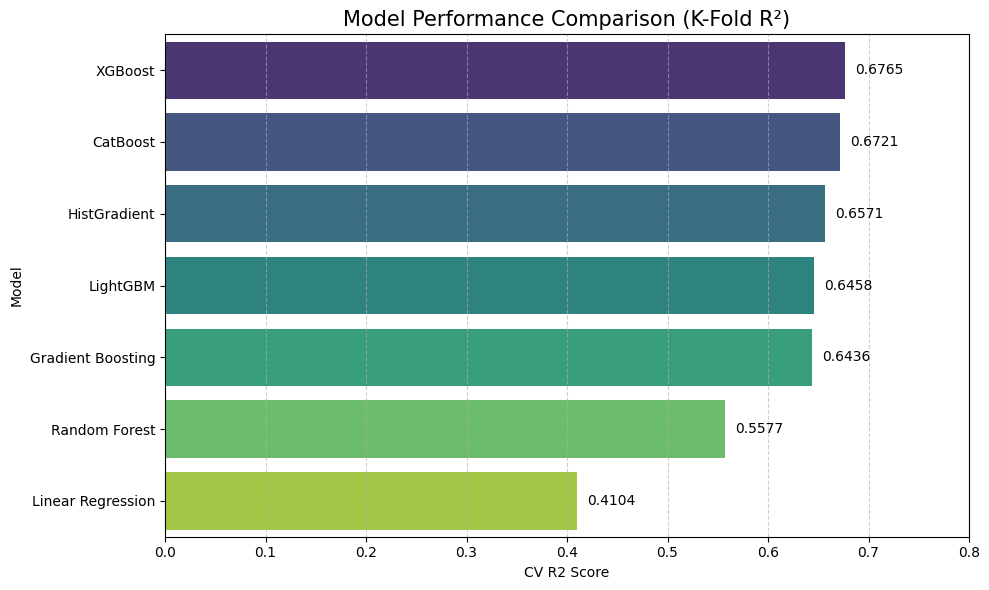

In [24]:
data = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'Gradient Boosting', 'LightGBM', 'CatBoost', 'HistGradient'],
    'CV R2 Score': [0.4104, 0.5577, 0.6765, 0.6436, 0.6458, 0.6721, 0.6571]
}

# 2. Create DataFrame and Sort
df_comparison = pd.DataFrame(data)
df_comparison = df_comparison.sort_values(by='CV R2 Score', ascending=False).reset_index(drop=True)

# 3. Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='CV R2 Score', y='Model', hue='Model', data=df_comparison, palette='viridis', legend=False)
plt.title('Model Performance Comparison (K-Fold R²)', fontsize=15)
plt.xlim(0, 0.8)  # Set limit to make differences clearer
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add text labels
for index, value in enumerate(df_comparison['CV R2 Score']):
    plt.text(value + 0.01, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()

Out top 2 models are Catboost and Xgboost. While CatBoost is excellent (especially for raw categorical data), XGBoost is likely the better choice for our model as we already did extensive feature engineering and encoding.

# Best Model

We work with Xgboost due to its high R square value so far and overall customizability.

**Why this model?**

* Mimics Industry Logic: Tree models use "thresholds" (e.g., "Is Budget > $100M?") rather than straight-line math, matching how studios treat Blockbusters and Indie films as completely different categories.

* Captures "Hidden" Rules: They automatically learn complex interactions (e.g., "High Budget only succeeds if Genre is Action") without you having to manually code them.

Enables "Optimistic" Predictions: XGBoost specifically supports Quantile Regression, allowing us to target the 70th percentile (potential revenue) rather than the average, which could be critical for predicting hits.

* Prevents Memorization: Unlike older models, XGBoost has built-in "Regularization" (penalties for complexity) that stops it from memorizing specific movies in our small dataset.

## Initial Xgboost

We use this section to identify issues with our current model and explore ways to fix them.

**Key issues so far**

* Noisy data (like during covid) may be harming our model. We will remove the films during lockdown period to see if performance improves.

* There might be noisy features that are not improving our model performance

* The mix of high budget movies and low budget movies may be confusing our model. As models regress to the mean our model may underpredict major blockbusters. We may need to figure out ways to prioritize high revenue films



Here we remove the covid movies and noisy features

In [25]:
# We load the initial file again so that we can run transformations from the start

df_model = df_model_initial.copy()
df_model.shape

(1713, 65)

We filter out the covid era films as movies that played during lockdown don't reflect usual conditions at all and they end up confusing our model

In [26]:
# Convert to datetime
df_model['release_date'] = pd.to_datetime(df_model['release_date'])

# Now define COVID period
covid_start = pd.to_datetime('2020-03-01')
covid_end = pd.to_datetime('2021-07-01')

# Filter out COVID movies
covid_mask = (df_model['release_date'] >= covid_start) & (df_model['release_date'] <= covid_end)

print(f"COVID movies: {covid_mask.sum()}")
print(f"Non-COVID movies: {(~covid_mask).sum()}")

# Filter
df_no_covid = df_model[~covid_mask].copy()

COVID movies: 55
Non-COVID movies: 1658


In [27]:
# We drop the text columns and other columns we don't use in the model

columns_to_drop = [
    'director_popularity',
    'main_actor_popularity',
    'cast_popularity_sum',
    'imdb_id',
    'collection_name',
    'collection_id',
    'keywords',
    'production_companies',
    'director',
    'director_id',
    'top_cast',
    'main_actor_name',
    'main_actor_id',
    'primaryTitle',
    'Distributor',
    'release_date',
    'holiday_name',
    'mpaa_rating',
    'genres',
    'prequel_revenue', # We created an updated one later on
    'main_production_company',
]
df_no_covid = df_no_covid.drop(columns=columns_to_drop, errors='ignore')

In [28]:
df_no_covid.columns

Index(['budget', 'first_week_revenue', 'runtimeMinutes', 'Theaters', 'year',
       'is_major_holiday', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'competition_count', 'director_bankability',
       'actor_bankability', 'director_experience', 'is_covid_period',
       'dist_cat_Medium', 'dist_cat_Small', 'distributor_bankability',
       'mpaa_rank', 'has_top_yield_genre', 'has_high_yield_genre',
       'has_medium_yield_genre', 'has_low_yield_genre', 'budget_tier_numeric',
       'has_prequel', 'prequel_revenue_fixed', 'franchise_position',
       'years_since_last_installment', 'Source_Comic_Graphic_Novel',
       'budget_per_theater', 'avg_ticket_price', 'consumer_sentiment'],
      dtype='object')

In [29]:
# We drop the target and the budget variable which we will log transform
cols_to_drop = ['first_week_revenue', 'budget','is_covid_period','director_bankability','has_prequel'] # We try dropping a few other columns that may be potentially harming the model
X = df_no_covid.drop(columns=cols_to_drop)

# Transformation
X['budget_log'] = np.log1p(df_no_covid['budget'])
y = np.log1p(df_no_covid['first_week_revenue']) # We log transform the target

# Handle Missing Values
X = X.fillna(0)

In [30]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter tuning

We do some hyperparameter tuning to understand what the best parameters are for our model. We will use those values for reference and tweak accordingly.

In [31]:
# 1. Define the Parameter Grid (The "Search Space")
# We focus on the parameters that control "Aggression" vs. "Overfitting"
param_grid = {
    # Control Under-prediction Bias
    'quantile_alpha': [0.60, 0.65, 0.70, 0.75, 0.80],  # Try being more aggressive

    # Control Outlier Isolation (Critical for Avatar)
    'min_child_weight': [1, 2, 5, 10],                # 1 allows isolating single movies
    'gamma': [0, 0.1, 0.2],                           # 0 allows greedy splits

    # Tree Structure
    'max_depth': [5, 6, 8, 10],                       # Deeper trees capture complex hits
    'subsample': [0.8, 0.9, 1.0],                     # 1.0 ensures trees see all blockbusters

    # Regularization (Don't let it get too stiff)
    'learning_rate': [0.01, 0.02, 0.05],
    'n_estimators': [1000, 1500, 2000]
}

# 2. Initialize the Base Model
xgb_base = XGBRegressor(
    objective='reg:quantileerror',
    n_jobs=-1,
    random_state=42,
    verbosity=3,
    reg_lambda=1.0, # Keep some defaults fixed to save time
    reg_alpha=0.1
)

# 3. Initialize the Tuner
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=50,              # Try 50 random combinations
    scoring='neg_mean_absolute_error', # Optimize for MAE (or use 'r2')
    cv=3,                   # 3-Fold CV to save time
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 4. RE-CALCULATE WEIGHTS (Ensure they are ready)
y_train_real = np.expm1(y_train)


# 5. RUN TUNING (The Important Part)
# We pass sample_weight HERE. Scikit-Learn will automatically slice
# the weights to match the Train/Validation folds internally.
print("Starting Hyperparameter Tuning...")
random_search.fit(
    X_train,
    y_train # <--- This is the magic argument
)

# 6. GET BEST RESULTS
print("\n--- Tuning Complete ---")
print(f"Best Params: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

# 7. UPDATE YOUR MODEL
best_model = random_search.best_estimator_

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[13:53:37] ======== Monitor (0): HostSketchContainer ========
[13:53:37] AllReduce: 0.005023s, 1 calls @ 5023us

[13:53:37] MakeCuts: 0.005108s, 1 calls @ 5108us

[13:53:37] INFO: /workspace/src/data/iterative_dmatrix.cc:56: Finished constructing the `IterativeDMatrix`: (1326, 41, 54366).
[13:53:37] DEBUG: /workspace/src/gbm/gbtree.cc:127: Using tree method: 0
[13:53:42] ======== Monitor (0): GBTree ========
[13:53:42] BoostNewTrees: 4.94947s, 2000 calls @ 4949470us

[13:53:42] CommitModel: 0.001806s, 2000 calls @ 1806us

[13:53:42] ======== Monitor (0): HistUpdater ========
[13:53:42] BuildHistogram: 0.688835s, 10000 calls @ 688835us

[13:53:42] EvaluateSplits: 2.67412s, 12000 calls @ 2674115us

[13:53:42] InitData: 0.060241s, 2000 calls @ 60241us

[13:53:42] InitRoot: 0.468282s, 2000 calls @ 468282us

[13:53:42] LeafPartition: 0.032256s, 2000 calls @ 32256us

[13:53:42] UpdatePosition: 0.4

### Running our Model

We use the parameter values from hyperparameter tuning as reference for our actual model we will be using going forward.

In [32]:
# 1. MODEL INITIALIZATION

xgb = XGBRegressor(
    # Core Parameters
    n_estimators=1000,          # Number of trees
    learning_rate=0.05,         # Low learning rate for stability (Regularization)
    max_depth=6,                # Limit depth to prevent overfitting (Regularization)

    # Regularization Parameters
    min_child_weight=10,        # Min samples per leaf (like min_samples_leaf)
    reg_alpha=0.1,              # L1 regularization (Lasso) - feature selection
    reg_lambda=1.0,             # L2 regularization (Ridge) - shrinks weights
    gamma=0.1,                  # Min loss reduction for split (pruning)

    # Subsampling (Reduces Overfitting)
    subsample=0.8,              # Use 80% of data per tree
    colsample_bytree=0.8,       # Use 80% of features per tree
    colsample_bylevel=0.8,      # Use 80% of features per level

    # Other
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# 2. FIT MODEL


xgb.fit(X_train, y_train)

# 3. PREDICTIONS (Real Dollars)

y_train_pred = np.expm1(xgb.predict(X_train))
y_test_pred = np.expm1(xgb.predict(X_test))
y_train_actual = np.expm1(y_train)
y_test_actual = np.expm1(y_test)

# 4. METRICS
print("XGBOOST RESULTS (Real Dollars)")
print("\nTest Set:")
print(f"  R²:   {r2_score(y_test_actual, y_test_pred):.4f}")
print(f"  RMSE: ${np.sqrt(mean_squared_error(y_test_actual, y_test_pred)):,.0f}")
print(f"  MAE:  ${mean_absolute_error(y_test_actual, y_test_pred):,.0f}")

XGBOOST RESULTS (Real Dollars)

Test Set:
  R²:   0.6517
  RMSE: $25,005,785
  MAE:  $14,315,008


In [33]:
# CROSS-VALIDATION

def r2_real_dollars(y_true, y_pred):
    return r2_score(np.expm1(y_true), np.expm1(y_pred))

cv_scores = cross_val_score(xgb, X_train, y_train, cv=10,
                            scoring=make_scorer(r2_real_dollars), n_jobs=-1)

print("5-FOLD CROSS VALIDATION")
print(f"CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"Folds: {cv_scores.round(4)}")

5-FOLD CROSS VALIDATION
CV R²: 0.7102 (+/- 0.0827)
Folds: [0.6895 0.5441 0.7897 0.7483 0.7042 0.6982 0.7753 0.7979 0.7735 0.5818]


The cross validation shows different R square values due to the presence of few high revenue films in the dataset which are very difficult to predict (compared to low revenue films)

CV R² (from predictions): 0.7020


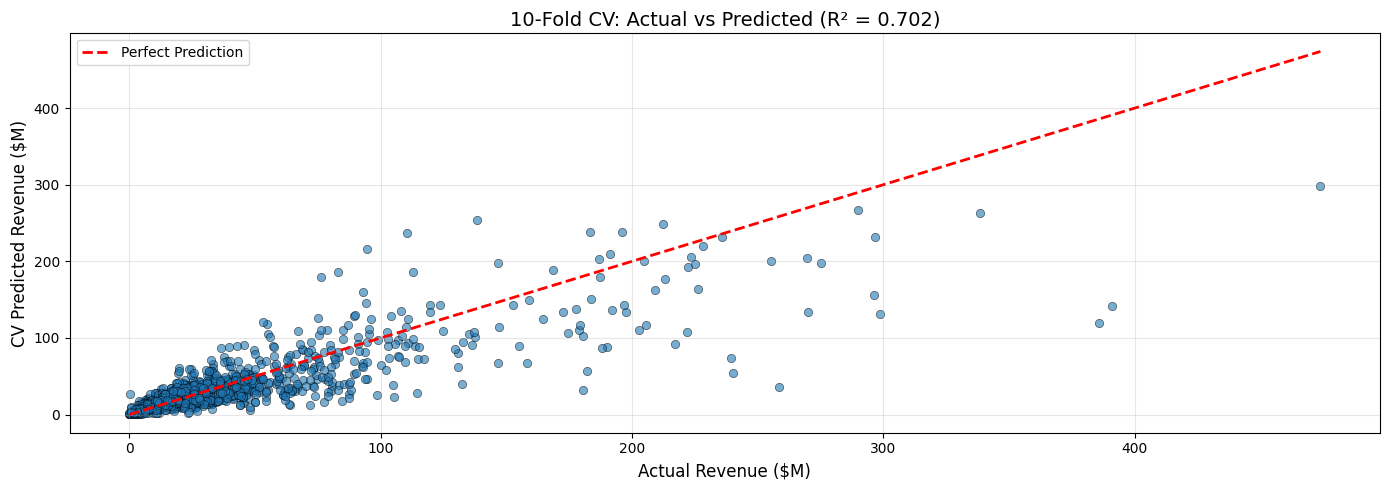

In [34]:
# Get CV predictions (out-of-fold predictions for all samples)
y_pred_cv_log = cross_val_predict(xgb, X_train, y_train, cv=10, n_jobs=-1)

# Convert to real dollars
y_pred_cv = np.expm1(y_pred_cv_log)
y_actual_cv = np.expm1(y_train)

cv_r2 = r2_score(y_actual_cv, y_pred_cv)

print(f"CV R² (from predictions): {cv_r2:.4f}")

# --- Visualize ---
fig, ax1 = plt.subplots(figsize=(14, 5)) # Changed axes to ax1

# Plot 1: Actual vs CV Predicted
ax1.scatter(y_actual_cv/1e6, y_pred_cv/1e6, alpha=0.6, edgecolors='black', linewidth=0.5)
max_val = max(y_actual_cv.max(), y_pred_cv.max()) / 1e6
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Revenue ($M)', fontsize=12)
ax1.set_ylabel('CV Predicted Revenue ($M)', fontsize=12)
ax1.set_title(f'10-Fold CV: Actual vs Predicted (R² = {cv_r2:.3f})', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

Our model is able to capture around 70% of the variation in the dataset overall. However, from the plot above it appears that the model underpredicts a lot of the blockbuster films that make a lot of revenue. This happens because models tend to **regress to the mean** to reduce errors and our model is currently a genralized model that considers all kinds of movies. We will now optimize it further to make it work for major blockbusters.

## Looking into Issues

We take a look at the high revenue movies which our model isn't good at predicting

In [35]:
# We load the initial file again so that we can run transformations from the start

df_model = df_model_initial.copy()
df_model.shape

(1713, 65)

In [36]:
# Convert to datetime
df_model['release_date'] = pd.to_datetime(df_model['release_date'])

# Now define COVID period
covid_start = pd.to_datetime('2020-03-01')
covid_end = pd.to_datetime('2021-07-01')

# Filter out COVID movies
covid_mask = (df_model['release_date'] >= covid_start) & (df_model['release_date'] <= covid_end)

print(f"COVID movies: {covid_mask.sum()}")
print(f"Non-COVID movies: {(~covid_mask).sum()}")

# Filter
df_no_covid = df_model[~covid_mask].copy()

COVID movies: 55
Non-COVID movies: 1658


In [37]:
# TOP REVENUE FILMS WITH TITLES

# Assuming df_no_covid or df_filtered has 'primaryTitle' column
# Adjust column names as needed

top_films = df_no_covid.loc[df_no_covid.index, ['primaryTitle', 'first_week_revenue', 'Theaters', 'budget']].copy()
top_films = top_films.sort_values('first_week_revenue', ascending=False)

print("=" * 105)
print("TOP 20 FILMS BY FIRST WEEK REVENUE")
print("=" * 105)
print(f"\n{'Rank':<6} {'primaryTitle':<40} {'Revenue':>20} {'Theaters':>15} {'Budget':>18}")
print("-" * 105)
for i, (idx, row) in enumerate(top_films.head(20).iterrows(), 1):
    title = row['primaryTitle'][:38] if len(row['primaryTitle']) > 38 else row['primaryTitle']
    print(f"{i:<6} {title:<40} ${row['first_week_revenue']:>18,.0f} {row['Theaters']:>15,.0f} ${row['budget']:>17,.0f}")

TOP 20 FILMS BY FIRST WEEK REVENUE

Rank   primaryTitle                                          Revenue        Theaters             Budget
---------------------------------------------------------------------------------------------------------
1      Avengers: Endgame                        $       473,894,638           4,662 $      356,000,000
2      Star Wars: Episode VII - The Force Awa   $       390,856,054           4,134 $      245,000,000
3      Spider-Man: No Way Home                  $       385,865,477           4,336 $      200,000,000
4      Avengers: Infinity War                   $       338,332,540           4,474 $      300,000,000
5      Deadpool & Wolverine                     $       298,575,919           4,210 $      200,000,000
6      Star Wars: Episode VIII - The Last Jed   $       296,602,356           4,232 $      300,000,000
7      Jurassic World                           $       296,211,655           4,274 $      150,000,000
8      Black Panther             

We mostly have major Marvel titles and star wars films. We will attempt to capture these major hits using a few additional features before our final model

## Additional Feature Engineering

We try out some additional features here to improve our model

### Inflation

We inflate our budget and revenue values so that the model better understands the true nature of our budgets and revenue

In [38]:
# ==============================================================================
# 1. INFLATION (UPDATE EXISTING COLUMNS)
# ==============================================================================
# We treat the "Current Value" as needing adjustment to 2025 dollars.

# Target CPI (2025 Estimate based on Q3/Q4 projections)
TARGET_CPI = 322.3

# Full Annual Average CPI-U Data (Source: US Bureau of Labor Statistics)
cpi_data = {
    2009: 214.5,
    2010: 218.1,
    2011: 224.9,
    2012: 229.6,
    2013: 233.0,
    2014: 236.7,
    2015: 237.0,
    2016: 240.0,
    2017: 245.1,
    2018: 251.1,
    2019: 255.7,
    2020: 258.8,
    2021: 271.0,
    2022: 292.7,
    2023: 304.7,
    2024: 314.1,
    2025: 322.3
}

def get_inflation_factor(year):
    # If year is missing (e.g., 2026), assume it's current (factor = 1.0)
    source_cpi = cpi_data.get(int(year), TARGET_CPI)
    return TARGET_CPI / source_cpi

# Inflate the Money Columns in your DF
if 'budget' in df_no_covid.columns:
    df_no_covid['budget_real'] = df_no_covid['budget'] * df_no_covid['year'].apply(get_inflation_factor)

if 'first_week_revenue' in df_no_covid.columns:
    df_no_covid['revenue_real'] = df_no_covid['first_week_revenue'] * df_no_covid['year'].apply(get_inflation_factor)

### Major Franchises

We make a feature identifying the major franchises that have earned billions in the box office over the years. This should help the model fight underprediction to some extent.

In [39]:
billion_franchises = [
    'avatar', 'avengers', 'star wars', 'jurassic', 'lion king',
    'frozen', 'incredibles', 'spider-man', 'black panther'
]

df_no_covid['is_billion_franchise'] = df_no_covid['primaryTitle'].str.lower().apply(
    lambda x: 1 if any(f in x for f in billion_franchises) else 0
)

print(f"Billion-dollar franchise films: {df_no_covid['is_billion_franchise'].sum()}")

Billion-dollar franchise films: 28


## Final Model

Here we work with the model we finally picked

In [40]:
columns_to_drop = [
    'director_popularity',
    'main_actor_popularity',
    'cast_popularity_sum',
    'imdb_id',
    'collection_name',
    'collection_id',
    'keywords',
    'production_companies',
    'director',
    'director_id',
    'top_cast',
    'main_actor_name',
    'main_actor_id',
    'primaryTitle',
    'Distributor',
    'release_date',
    'holiday_name',
    'mpaa_rating',
    'genres',
    'prequel_revenue', # We created an updated one later on
    'main_production_company',
]
df_no_covid = df_no_covid.drop(columns=columns_to_drop, errors='ignore')

In [41]:
df_no_covid.columns

Index(['budget', 'first_week_revenue', 'runtimeMinutes', 'Theaters', 'year',
       'is_major_holiday', 'month_August', 'month_December', 'month_February',
       'month_January', 'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday', 'competition_count', 'director_bankability',
       'actor_bankability', 'director_experience', 'is_covid_period',
       'dist_cat_Medium', 'dist_cat_Small', 'distributor_bankability',
       'mpaa_rank', 'has_top_yield_genre', 'has_high_yield_genre',
       'has_medium_yield_genre', 'has_low_yield_genre', 'budget_tier_numeric',
       'has_prequel', 'prequel_revenue_fixed', 'franchise_position',
       'years_since_last_installment', 'Source_Comic_Graphic_Novel',
       'budget_per_theater', 'avg_ticket_price', 'consumer_sentiment',
       'budget_real', 'revenue_real', 'is_billion_franch

### Key Decisions

* We add inflated revenue and budget features
* We remove the bankability features as they hurt the model, likely due to issues like imputations for first time directors. Trying our anything else would lead to data leakage so we just chose to remove these.
* The competition count feature can't account for the scale of the movie being released in the same window. A small 20 million budget production won't affect the screeenings the same way a 200 million budget mega blockbuster would. There are also complex effects like the Barbenheimer effect which the model can't capture yet as we don't have a lot of data like that.
* The day of the week feature was a bit erratic as we saw in our initial EDA, so we decided to leave this feature for now.
* We are using log theatres to smooth out the effect of theatres in our model.

In [42]:
# We drop the target and the budget variable which we will log transform
# We drop some harmful features as well after some trial and error
cols_to_drop = ['first_week_revenue', 'budget','is_covid_period','Source_Comic_Graphic_Novel','Theaters','budget_real', 'revenue_real','distributor_bankability','director_bankability',
       'actor_bankability','competition_count', 'day_Monday',
       'day_Saturday', 'day_Sunday', 'day_Thursday', 'day_Tuesday',
       'day_Wednesday']
X = df_no_covid.drop(columns=cols_to_drop)

# Transformation
X['budget_log'] = np.log1p(df_no_covid['budget_real'])
X['log_theaters'] = np.log1p(df_no_covid['Theaters'])
y = np.log1p(df_no_covid['revenue_real']) # We log transform the target

# Handle Missing Values
X = X.fillna(0)

In [43]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.columns

Index(['runtimeMinutes', 'year', 'is_major_holiday', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'director_experience',
       'dist_cat_Medium', 'dist_cat_Small', 'mpaa_rank', 'has_top_yield_genre',
       'has_high_yield_genre', 'has_medium_yield_genre', 'has_low_yield_genre',
       'budget_tier_numeric', 'has_prequel', 'prequel_revenue_fixed',
       'franchise_position', 'years_since_last_installment',
       'budget_per_theater', 'avg_ticket_price', 'consumer_sentiment',
       'is_billion_franchise', 'budget_log', 'log_theaters'],
      dtype='object')

### Final Optimization

**Key consideration**

* By default, most regression models (like standard XGBoost) try to predict the Average (Mean). Using quantile_alpha=0.7 forces the model to predict the 70th Percentile instead. The right skewness of the data indicates the "Average" movie makes very little money. This is an issue because blockbusters the size of Avatar are not that common so we need to handle the effect of low revenue films. Here, because the "punishment" for underpredicting is much stricter ($0.7$ vs $0.3$), the model naturally pushes its predictions upwards to be safe. It would rather overshoot slightly than risk the heavy penalty of undershooting.

In [45]:
# 1. MODEL WITH QUANTILE
xgb = XGBRegressor(
    # Core Parameters
    n_estimators=1500,     # Number of trees
    learning_rate=0.02,    # Low learning rate for stability (Regularization)
    max_depth=6,           # Limit depth to prevent overfitting (Regularization)

    # Regularization Parameters
    min_child_weight=2,   # Min samples per leaf (like min_samples_leaf).
    #We keep it at 2 as there might be few specific films that do very well in the box office
    reg_alpha=0.1,        # L1 regularization (Lasso) - feature selection
    reg_lambda=1.0,       # L2 regularization (Ridge) - shrinks weights
    gamma=0.1,            # Min loss reduction for split (pruning)

    # Subsampling (Reduces Overfitting)
    subsample=0.8,        # Use 80% of data per tree
    colsample_bytree=0.8, # Use 80% of features per tree
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    objective='reg:quantileerror',
    quantile_alpha=0.7  # Slight upward bias
)


# FIT
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=2, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=-1, num_parallel_tree=None, ...)

### Feature Importance and SHAP


**Feature importance through gain**

* Feature importance are scores assigned to each input features that indicate, on average across the entire dataset, how much that feature contributes to the overall model prediction.

Gain measures the average improvement in accuracy (reduction in loss) brought by a feature to the branches it is on.

Translation: "When the model makes a decision based on this feature, how much does it clear up the confusion?" High gain means the feature creates very distinct "groups" of movies (e.g., "High Revenue" vs. "Low Revenue").

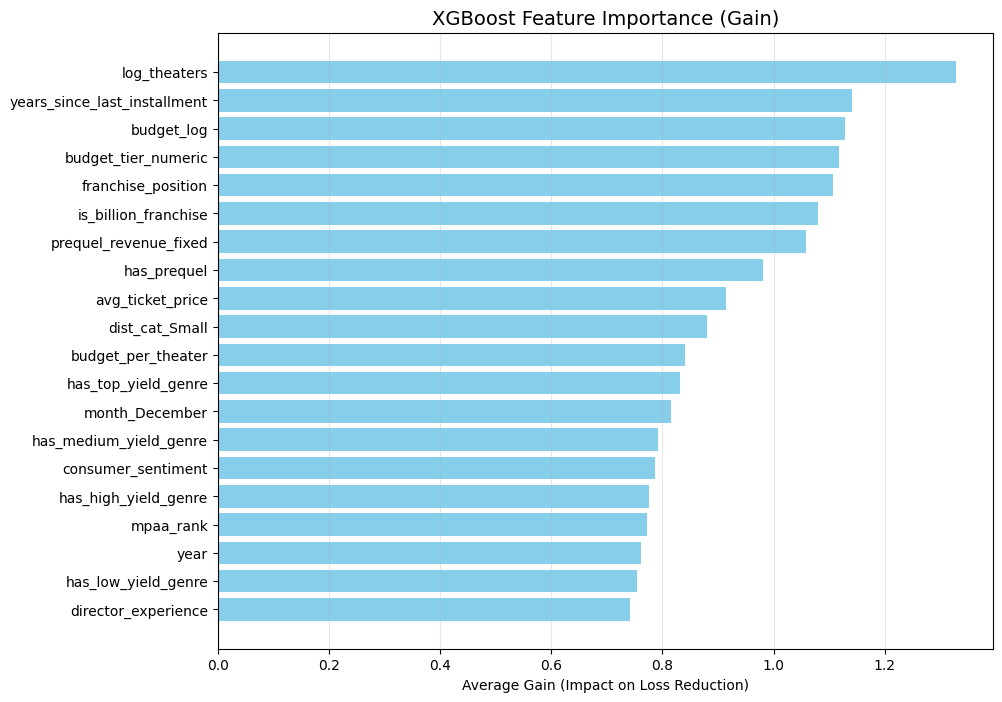

In [46]:
# Feature importance
# Get importance dictionary
importance_data = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance_data.items()), columns=['Feature', 'Gain'])

# Sort and Plot
importance_df = importance_df.sort_values(by='Gain', ascending=True).tail(20) # Top 20

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Gain'], color='skyblue')
plt.title('XGBoost Feature Importance (Gain)', fontsize=14)
plt.xlabel('Average Gain (Impact on Loss Reduction)')
plt.grid(axis='x', alpha=0.3)
plt.show()

The model indicates that distribution power and franchise legacy are the overwhelming drivers of box office revenue. The "Gain" metric shows that log_theaters is the most dominant predictor, meaning the sheer number of screens a movie opens on is the strongest signal of financial success. This is followed closely by franchise dynamics—specifically the time gap between sequels (years_since_last_installment) and whether it belongs to a major IP (is_billion_franchise)—which outranks raw budget (budget_log) in importance. While release timing and economic factors play a role, the model is essentially saying that securing a wide release and leveraging audience anticipation are the keys to a high prediction.

**SHAP (SHapley Additive exPlanations)**

A SHAP value for a feature is the fair way to distribute the "payout" (the final prediction) among the features, considering all possible combinations of features. This gives us additional insight into how our model performed.

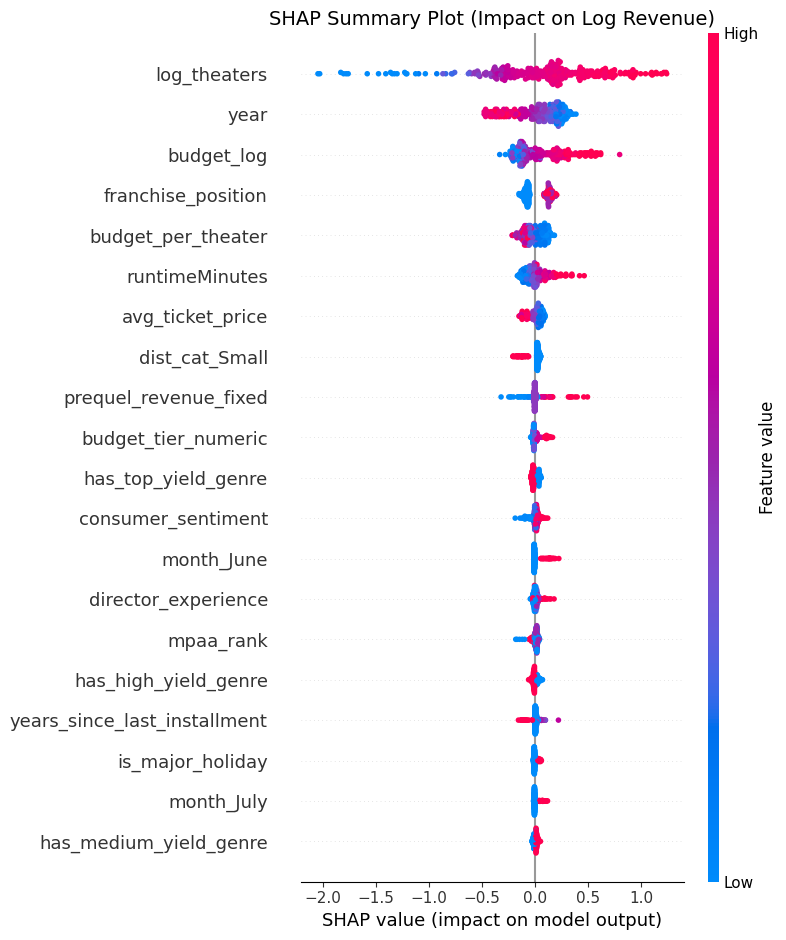

✅ SHAP Plot Generated.


In [47]:
try:
    # 1. Initialize Explainer
    explainer = shap.TreeExplainer(xgb)

    # 2. Calculate SHAP Values
    shap_values = explainer(X_test)

    # 3. SUMMARY PLOT
    plt.figure(figsize=(12, 10))
    plt.title("SHAP Summary Plot (Impact on Log Revenue)", fontsize=14)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.show()
    print("✅ SHAP Plot Generated.")

except Exception as e:
    # IF IT FAILS, JUST SKIP IT
    print(f"⚠️ SHAP Error: {e}")
    print("Likely due to mismatch in version type. You can run this on Colab")
    print("⏭️ Moving on to next block (Skipping SHAP)...")

This tells a much more nuanced story than the Gain chart. While the Gain chart  was important, this SHAP chart tells you how those features are pushing our predictions up or down. The SHAP analysis reveals that your model identifies market saturation and scale as the primary drivers of revenue, with log_theaters serving as the most powerful engine—opening on many screens drastically boosts predictions, while limited releases act as a severe anchor. Beyond distribution, the model explicitly rewards "Blockbuster DNA": high budgets (budget_log), longer runtimes (runtimeMinutes), and later franchise positions (franchise_position) all consistently push revenue estimates higher. Year shows a negative trend which is in line with the decline of box office performance lately (It has not reached pre covid levels even today). Low consumer sentiment and our EDA analysis also supports this.

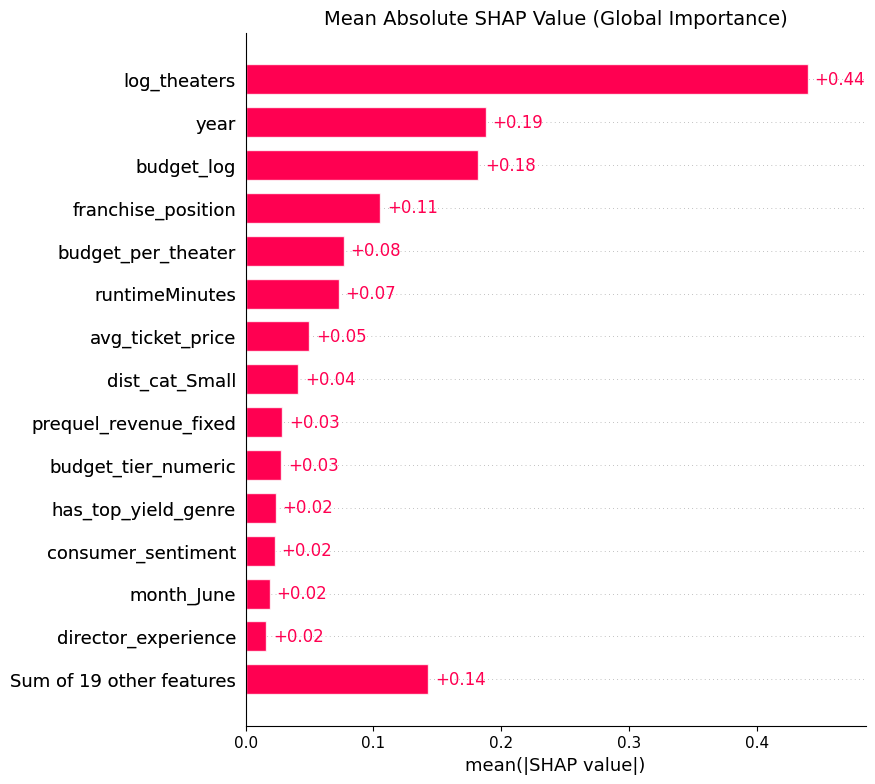

✅ SHAP Bar Plot Generated.


In [48]:
try:
    # 4. BAR PLOT (Global Importance)
    # Shows purely "How important is this feature?" regardless of direction
    plt.figure(figsize=(10, 8))
    plt.title("Mean Absolute SHAP Value (Global Importance)", fontsize=14)
    shap.plots.bar(shap_values, max_display=15, show=True)
    print("✅ SHAP Bar Plot Generated.")

except Exception as e:
    # IF IT FAILS, JUST SKIP IT
    print(f"⚠️ SHAP Bar Plot Error: {e}")
    print("Likely due to mismatch in version type. You can run this on Colab")
    print("⏭️ Moving on to next block (Skipping SHAP Bar Plot)...")

The Global SHAP importance plot definitively identifies market footprint as the primary driver of our revenue predictions, with log_theaters (+0.44) exerting more than double the average impact of any other feature. Interestingly, the model ranks release timing (year, +0.19) slightly above raw production spend (budget_log, +0.18), suggesting that broader market trends and inflation are stronger predictors of variance than the budget itself. A critical technical takeaway is the discrepancy with the previous Gain chart: while years_since_last_installment was structurally vital for building the tree, it drops out of the top SHAP rankings entirely, proving that while it helps organize the data, it does not move the final dollar prediction nearly as much as tangible factors like franchise_position (+0.11) or runtimeMinutes.

### Cross Validation and Final Performance

We do cross validation to get an idea about how our model actually performs. This will be the final performance of our model.

This portion is crucial because our R square value will be inflated if we get a lucky split (A split without the big bloclbusters with huge revenues which are much harder to predict. But our model needs these as we are predicting a major film like the 3rd Avatar film)


📊 Cross-Validation Results (10-Fold):
----------------------------------------
R² Score:  0.7433
RMSE:      $31.49 Million  (Standard Deviation of Error)
MAE:       $17.62 Million  (Average Miss)
----------------------------------------


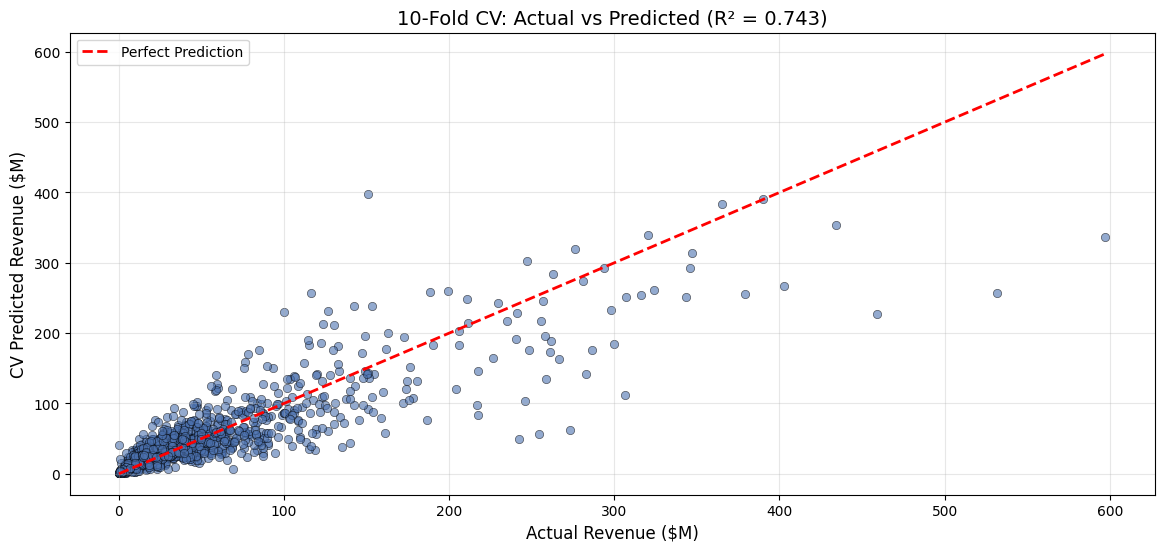

In [49]:
y_pred_cv_log = cross_val_predict(
    xgb,
    X_train,
    y_train,
    cv=10,
    n_jobs=-1
)

# CONVERT TO REAL DOLLARS (To ensure our metrics are calculated for real dollar values)
y_pred_cv = np.expm1(y_pred_cv_log)
y_actual_cv = np.expm1(y_train)

# CALCULATE METRICS
cv_r2 = r2_score(y_actual_cv, y_pred_cv)
cv_mse = mean_squared_error(y_actual_cv, y_pred_cv) # Calculate MSE
cv_rmse = np.sqrt(cv_mse) # Take square root to get RMSE
cv_mae = mean_absolute_error(y_actual_cv, y_pred_cv)

# PRINT RESULTS
print(f"\n📊 Cross-Validation Results (10-Fold):")
print(f"----------------------------------------")
print(f"R² Score:  {cv_r2:.4f}")
print(f"RMSE:      ${cv_rmse/1e6:,.2f} Million  (Standard Deviation of Error)")
print(f"MAE:       ${cv_mae/1e6:,.2f} Million  (Average Miss)")
print(f"----------------------------------------")

# VISUALIZE
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot: Actual vs CV Predicted
ax1.scatter(y_actual_cv/1e6, y_pred_cv/1e6, alpha=0.6, edgecolors='black', linewidth=0.5, color='#4C72B0')

# Reference Line
max_val = max(y_actual_cv.max(), y_pred_cv.max()) / 1e6
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Formatting
ax1.set_xlabel('Actual Revenue ($M)', fontsize=12)
ax1.set_ylabel('CV Predicted Revenue ($M)', fontsize=12)
ax1.set_title(f'10-Fold CV: Actual vs Predicted (R² = {cv_r2:.3f})', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

These are robust scores we got after cross validaiton and they represent the true picture of our model. Overall the scores are dragged down by a few major massive blockbuster hits that are incredibly hard to predict. Furthermore, the model was optimized for blockbusters and not for error reduction overall, so the rate of error in smaller films also went up to compensate for better prediction of big releases.

**R Square**

Our R Square value has gone up. It is still difficult to capture the performance of some outlier films, but our model can successfully capture 74.3% of the variation. We are going forward with this because our dataset was already filtered to keep big releases. Small indie films don't affect our predictions.


**Why MAE and RMSE may look high**

* The MAE and RMSE values will naturally be higher now as we are using inflated budget and revenue. Also our model is now tweaked to be better at predicting blockbusters (Using quantileerror).

* By definition, predicting the 70th percentile will always have a worse RMSE than predicting the Mean (because the Mean is the unique value that minimizes RMSE), but it helps our specific case of predicting major blockbusters (At the cost of worse predcition for small releases that aren't important for our case).

* Another major consideration is our dataset was filtered at the start to include only top hits of the past 16 years and we furthered filtered to removve films with under 100,000 budget and under 100 theaters release. By removing the small movies, we removed all the "easy" $1M errors and kept only the "expensive" multi million errors. So our dataset is free from small noisy films that could have potentially dragged down our MAE and RMSE scores significantly

* For our case, we needed a model optimized to perdict a major franchise like Avatar and thus we prepared our dataset and modelled accordingly. As a result the relatively higher MAE and RMSE values are expected. Cross validation further ensured we predicted all the few major releases that are very difficult to predict, dragging our error scores up even more

**MAE**

On Average our model misses predictions by 17.62 Million USD. This is acceptable for our use case as our dataset was already filtered to keep only big releases. Furthermore, this value is driven further up by blockbusters that drive up this error. **The hype behind major blockbusters like Avengers Endgame cannot be captured by the model easily even after the features we made**. It also doesn't help that models tend to regress to the mean to reduce error, though we tried to tackle that ot some extent.

**RMSE**

The 31 Million USD RMSE confirms the presence of big outliers. Though these values are affected by those mega hits, our model does a fair job at predicting a lot of the bigger films.


We also take a look at MAPE to get a full understanding of our model. The overall MAPE will likely be distorted by the presence of many smaller releases (Not noisy indie films, but also not in the major blockbuster category). We will calculate weighted MAPE to understand how well our model does when it comes to blockbusters like Avatar.

In [50]:
# (Average of percentage errors: prone to blowing up on small movies)
mape = mean_absolute_percentage_error(y_actual_cv, y_pred_cv)

# CALCULATE WMAPE (Weighted MAPE)
# (Total Error / Total Revenue: weights big movies more heavily)
total_actual_revenue = np.sum(y_actual_cv)
total_absolute_error = np.sum(np.abs(y_actual_cv - y_pred_cv))
wmape = total_absolute_error / total_actual_revenue

# PRINT COMPARISON
print(f"📉 ERROR METRICS COMPARISON")
print(f"========================================")
print(f"Standard MAPE:  {mape:.1%}   (Sensitive to Flops)")
print(f"Weighted MAPE:  {wmape:.1%}   (Sensitive to Blockbusters)")
print(f"----------------------------------------")
if mape > wmape * 1.5:
    print("   Your model is failing on small movies (Flops) but working well on Blockbusters.")
else:
    print("⚠️ DIAGNOSIS: The error is consistent across all movies.")
print(f"========================================")

# Create a dataframe to see exactly which movies are ruining the score
errors_df = pd.DataFrame({
    'Actual ($M)': y_actual_cv / 1e6,
    'Predicted ($M)': y_pred_cv / 1e6
})

# Calculate individual errors
errors_df['Error ($M)'] = errors_df['Predicted ($M)'] - errors_df['Actual ($M)']
errors_df['MAPE_Indiv'] = np.abs(errors_df['Error ($M)']) / errors_df['Actual ($M)']

print("\n🔍 TOP 5 MAPE DESTROYERS (Why your MAPE is 70%):")
print("These are likely low-grossing films where you predicted 'optimistically'.")
print("-" * 60)
# Sort by highest percentage error and show top 5
print(errors_df.sort_values('MAPE_Indiv', ascending=False).head(10).to_string(float_format="%.2f"))

📉 ERROR METRICS COMPARISON
Standard MAPE:  73.2%   (Sensitive to Flops)
Weighted MAPE:  36.3%   (Sensitive to Blockbusters)
----------------------------------------
   Your model is failing on small movies (Flops) but working well on Blockbusters.

🔍 TOP 5 MAPE DESTROYERS (Why your MAPE is 70%):
These are likely low-grossing films where you predicted 'optimistically'.
------------------------------------------------------------
      Actual ($M)  Predicted ($M)  Error ($M)  MAPE_Indiv
184          0.28           41.10       40.82      143.83
1585         0.73           21.36       20.63       28.14
874          0.10            2.96        2.85       28.00
1488         0.06            1.52        1.46       26.34
1397         1.04           15.47       14.43       13.92
400          0.07            0.74        0.67        9.00
565          0.55            4.83        4.29        7.84
459          4.14           29.17       25.04        6.05
1026         1.03            6.50        5.46 

It is very evident that the MAPE is driven up due to small releases which have more error now as we tweaked the model and optimized it for blockbusters like Avatar 3. The WMAPE of 36% indicates that our model is usually off by 36% when it comes to predicting big blockbusters. A big contributor of this error are a few major releases like Avengers Endgame and Star Wars films the hype of shich were nearly impossible to capture using our model. The data we have is more fit for movies like Avatar which has long legs and people often watch for the entertainment and quality factor. For our case, we consider this WMAPE acceptable as we ensured that we tried predicting all major releases using cross validation and tweaked our model likewise even at the cost of performance on smaller films.

# Avatar Prediction

**Key points**

* We will retrain our model on full data
* We will find the feature values for Avatar 3
* We will find the final prediction

## Feature Summary

Here we have a summary of the features that made our final model.

**Time & Seasonality**

* runtimeMinutes: The film's duration; longer runtimes often signal "event" movies but reduce the max number of daily screenings.

* year: Captures the long-term trends in cinema attendance and gradual inflation over the decades.

* is_major_holiday: Flags if the release aligns with peak movie-going windows (Christmas, Memorial Day, etc.).

* month_[Name]: Captures seasonal audience behavior (e.g., the massive Summer blockbuster season vs. the quiet "dump months").

**Movie DNA & Talent**
* director_experience: A metric quantifying the director’s past commercial track record and industry seniority.

* mpaa_rank: Ordinal score of the age rating (PG-13 vs R), which dictates the maximum size of the potential audience.

* dist_cat: Indicates the marketing power of the studio; smaller distributors usually cannot secure as many screens as major ones.

* has_[tier]_yield_genre: Groupings of genres based on their historical profitability (e.g., Action/Adventure vs. Drama).

**Franchise & IP Dynamics**
* has_prequel: Indicates if the movie has an existing predecessor, leveraging a pre-built fanbase.

* prequel_revenue: The box office revenue of the previous movie in the series, acting as a strong baseline "anchor" for the new prediction.

* years_since_last_installment: Measures the gap between sequels to capture "pent-up demand" (like Avatar) or "loss of relevance."

* franchise_position: The installment number (e.g., Part 3), helping the model detect franchise fatigue or momentum.

* is_billion_franchise: A special flag for elite IP (MCU, Avatar, Star Wars) that operates on a completely different revenue scale than normal films.

**Financials & Market Context**
* budget_log: Log-transformed production cost, allowing the model to compare indie budgets and blockbuster budgets on a stable scale.

* budget_tier_numeric: Simplifies budget into categories (Low/Mid/High) to help the model apply different rules to different scales of film.

* log_theaters: Log-transformed opening screen count; the single strongest signal of studio confidence and distribution reach.

* budget_per_theater: A derived ratio showing how "premium" the production is relative to its release width.

* avg_ticket_price: Adjusts for the economic environment and ticket inflation of the specific release year.

* consumer_sentiment: A macro-economic indicator reflecting the general public's willingness to spend discretionary income on entertainment.

## Modeling

Here we retrain the final model we have on the full dataset

In [51]:
# Retraining the model with full data

X_full = X
y_full = y

# We must calculate weights based on the Real Dollar value of the full dataset
y_full_real = np.expm1(y_full)

# Using our exact validated parameters
xgb_final = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=6,
    min_child_weight=2,
    reg_alpha=0.1,
    reg_lambda=1.0,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    objective='reg:quantileerror',
    quantile_alpha=0.7  # Slight upward bias
)

# Fitting
print(f"Training Final Production Model on {len(X_full)} movies...")
xgb_final.fit(X_full, y_full)

print("Training Complete. Model is ready for Avatar 3.")

Training Final Production Model on 1658 movies...
Training Complete. Model is ready for Avatar 3.


In [52]:
X_full.columns

Index(['runtimeMinutes', 'year', 'is_major_holiday', 'month_August',
       'month_December', 'month_February', 'month_January', 'month_July',
       'month_June', 'month_March', 'month_May', 'month_November',
       'month_October', 'month_September', 'director_experience',
       'dist_cat_Medium', 'dist_cat_Small', 'mpaa_rank', 'has_top_yield_genre',
       'has_high_yield_genre', 'has_medium_yield_genre', 'has_low_yield_genre',
       'budget_tier_numeric', 'has_prequel', 'prequel_revenue_fixed',
       'franchise_position', 'years_since_last_installment',
       'budget_per_theater', 'avg_ticket_price', 'consumer_sentiment',
       'is_billion_franchise', 'budget_log', 'log_theaters'],
      dtype='object')

In [53]:
X_full.shape

(1658, 33)

## Preparing Information for Avatar 3

For the theatres, we take a look at previous releases and the budget of the movie to make a guess.

In [54]:
avatar_films = df_model_initial[df_model_initial['primaryTitle'].str.contains('Avatar', case=False, na=False)]
avatar_films[['primaryTitle', 'Theaters', 'budget']]

,primaryTitle,Theaters,budget
140,Avatar,3452.0,237000000
141,Avatar: The Way of Water,4202.0,350000000


In [55]:
# Movies with over 300 million Budget
movies_over_300m_budget = df_model_initial[df_model_initial['budget'] > 300_000_000]
movies_over_300m_budget[['primaryTitle', 'Theaters', 'budget']].sort_values(by='budget', ascending=False)

,primaryTitle,Theaters,budget
9,Jurassic World: Dominion,4676.0,583900000
2,Star Wars: Episode IX - The Rise of Skywalker,4406.0,489900000
148,Mission: Impossible - The Final Reckoning,3857.0,400000000
5,Pirates of the Caribbean: On Stranger Tides,4155.0,379000000
135,Avengers: Endgame,4662.0,356000000
141,Avatar: The Way of Water,4202.0,350000000
70,Fast X,4046.0,340000000
559,Gladiator II,3573.0,310000000


In [56]:
print(f"Average Theaters: {movies_over_300m_budget['Theaters'].mean():,.0f}")

Average Theaters: 4,197


It seems that most films around this budget range start at more than 4000 theatres. Some early approximates suggest that Avatar will release in around 3800 theaters. But looking at the release of Avatar 2 (4202) and average of movies of this calibre (4197), we will use a theatre count closer to that (4120). We do so because Avatar 3 has one of the highest budgets in movie history and it may push up the number of theaters it screens in. It's a bit less than the Average but above the early estimates after considering past releases.

Even if the theater number is a bit more than the actual that can benefit our prediction in this case as this film is designed specifically for an IMAX 3D theatrical experience (Which is bound to get more revenue compared to the average theatre). Our model does not have the information about what kind of screen the movies will air on. So the few extra screens can compensate for the premium theatres Avatar will actually release in.

In [57]:
# Theatres log
np.log1p(4130)

np.float64(8.326274787396764)

In [58]:
# Budget Log
np.log1p(400_000_000)

np.float64(19.806975107572256)

In [59]:
# budget_per_theater

400_000_000/4130

96852.30024213075

We collect the other features as well

In [60]:
# Create a dictionary with the RAW values
avatar_dict = {
    # --- HARD STATS ---
    'budget_log': 19.806975107572256,
    'runtimeMinutes': 197,
    'log_theaters': 8.326274787396764,
    'year': 2025,
    'budget_tier_numeric': 4,
    'is_billion_franchise': 1,
    'budget_per_theater': 96852.30024213075,
    'director_experience': 2, # According to the scope of our dataset

    # --- DATE / SEASONALITY ---
    'is_major_holiday': 1,       # Christmas release
    'month_December': 1,         # Release Month
    # Set all other months to 0
    'month_August': 0, 'month_February': 0, 'month_January': 0,
    'month_July': 0, 'month_June': 0, 'month_March': 0, 'month_May': 0,
    'month_November': 0, 'month_October': 0, 'month_September': 0,


    #  MARKET
    'consumer_sentiment': 58.0,
    'avg_ticket_price': 11.31,

    # --- GENRE & RATING ---
    'mpaa_rank': 2,              # PG-13 (According to encoding)
    'has_top_yield_genre': 1,    # According to our encoding
    'has_high_yield_genre': 0,
    'has_medium_yield_genre': 0,
    'has_low_yield_genre': 0,

    # --- FRANCHISE ---
    'has_prequel': 1,
    'prequel_revenue_fixed': 197681686,
    'franchise_position': 3,
    'years_since_last_installment': 3,    # 2022 to 2025


    #  DISTRIBUTOR (20th Century)
    #  Assumes large category as we dropped it during dummy encoding
    'dist_cat_Medium': 0,
    'dist_cat_Small': 0
}

# Convert to DataFrame
avatar_df = pd.DataFrame([avatar_dict])

In [61]:
avatar_df.shape

(1, 33)

In [62]:
# Get the list of columns from  training data
# This is the "Source of Truth"
required_columns = X_full.columns.tolist()

# Reindex Avatar dataframe to match
# This effectively sorts the columns to match X_full exactly.
avatar_final = avatar_df[required_columns]

# SAFETY CHECK: Did we introduce any NaNs?
# If you forgot a column (e.g., 'month_July'), reindexing might fail or fill NaN.
# This check ensures you are safe.
if avatar_final.isnull().values.any():
    missing_cols = avatar_final.columns[avatar_final.isnull().any()].tolist()
    print(f"❌ CRITICAL ERROR: You are missing these columns in avatar_df: {missing_cols}")
else:
    print("✅ Columns aligned perfectly. Ready for prediction.")


✅ Columns aligned perfectly. Ready for prediction.


## Prediction

In [63]:
# 1. MAKE PREDICTION (Returns Log Value)
log_prediction = xgb_final.predict(avatar_final)

# 2. CONVERT LOG TO DOLLARS
# We use expm1 (e^x - 1) to reverse the log1p (ln(x + 1)) transformation
dollar_prediction = np.expm1(log_prediction)[0]

# 3. OUTPUT RESULT
print(f"==========================================")
print(f"PREDICTED OPENING WEEK FOR AVATAR 3:")
print(f"${dollar_prediction:,.2f}")
print(f"==========================================")

PREDICTED OPENING WEEK FOR AVATAR 3:
$183,674,720.00


My prediction is that Avatar: Fire and Ash will make **$183,674,720.00** in its first week (7 days).

This makes sense as movies like Avatar operate on completely different box office lifecycles compared to Marvel films. Marvel movies are "front-loaded" events driven by intense spoiler culture; fans rush to theaters immediately, leading to massive opening weekends that account for a huge chunk of their total gross, followed by steep weekly drops. In contrast, Avatar films are "back-loaded" spectacles driven by the 3D/IMAX experience. Because premium screens are limited and the appeal is visual rather than plot-twist dependent, audiences spread their viewing out over months, resulting in smaller openings but incredibly "long legs" where the film sustains high ticket sales for weeks or even months after release.

So even though the $180 M estimate may seem conservative for a film that made box office records, we have to understand that these films behave differently than the Marvel films which see a big chunk of revenue in the initial days. The low customer sentiment and overall low performance of movies in 2025 also indicates that Avatar 3 may not make as much as the 2nd film in its first week.

## SHAP

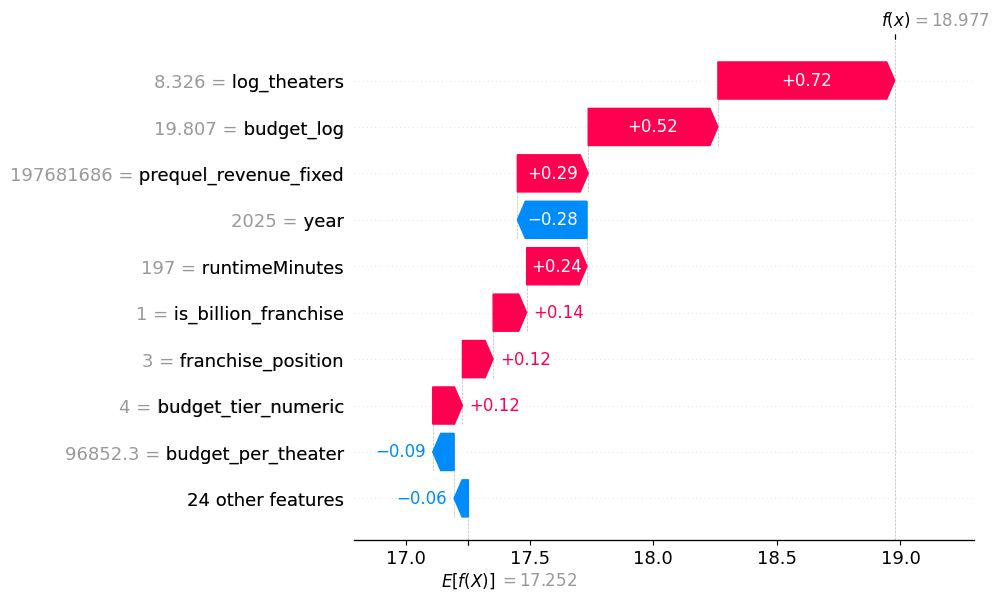

✅ Avatar Waterfall Plot Generated.


In [64]:
try:
    # We need to make sure it has the exact same columns as X_train
    # (re-calculating values specifically for this single row)
    shap_values_avatar = explainer(avatar_final)

    plt.figure(figsize=(10, 6))
    # This shows how each feature pushes the base value (average movie) up to the final prediction
    shap.plots.waterfall(shap_values_avatar[0])
    print("✅ Avatar Waterfall Plot Generated.")

except Exception as e:
    # IF IT FAILS, JUST SKIP IT
    print(f"⚠️ Avatar Waterfall Error: {e}")
    print("Likely due to mismatch in version type. You can run this on Colab")

The model predicts Avatar 3 will be a massive "super-blockbuster," lifting the forecast to a log-value of 18.977 (far above the average baseline of 17.252) primarily due to its overwhelming market presence and scale. The dominant forces driving this success are the saturation release strategy (log_theaters, +0.72) and the massive ~$400M production budget (budget_log, +0.52). The model further rewards the film's 3-hour runtime (+0.24) and the massive financial legacy of the previous film (+0.29) as positive demand signals rather than risks. The budget tier also signalled that the movie is a blockbuster tier film and sent a postitive signal. The only significant drag on the prediction is the year 2025 (-0.28), suggesting that the model is generally pessimistic about the current market climate.

# Reflection

* Some core challenges I ran into were related to hwo Machine Learning models behave. Most models revert to the mean. They are excellent at predicting the "average" movie (revenue between 10M–50M) but statistically terrified of predicting outliers like Avatar or Avengers. Switching the objective function to reg:quantileerror with alpha=0.7, but it came at the cost of the model getting worse at predicting smaller films.

* We only had a few thousand movies, and only a handful of true blockbusters. This made it harder for the model to understand how these movies behave. We had to filter our dataset further to remove noisy films that may harm the model, making our dataset even smaller. As time goes on and more blockbusters get released, the scope of creating a stronger model will only increase.

* Capturing Social Sentiment & Momentum could have made our model stronger. We were only able to capture the econmic landscape using inflation, consumer sentiment and changes in mocie ticket prices. We weren't able to use Wikipedia data due to timeframe limitations and we also couldn't use YouTube data to access issues. If we could access premium data that can capture social sentiment we may be able to improve our model further. Access to more specific data like which movies are being released in premium theaters (IMAX, 3D) and so on could have strengthened our model even more (As premium IMAX/3D screens would bring in more money than usual theatres. It is difficult to currently capture that with the data we have).